In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [3]:
config.H_target = 2* 0.3
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [4]:
import time
import datetime
import logging

logger = logging.getLogger()

def setup_file_logger(log_file='out.log'):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)
    logger.info("start")

setup_file_logger()

In [5]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func,name):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        
        if last_output[0] is None:
            X_OUTPUT = 1 # X_DEC
        else:
            X_OUTPUT = 0 # X_HAT_OUT
        val = self.func(last_output[X_OUTPUT], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()
        
    
    
    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)
    
class ParameterMetricCallback(Callback):
    def __init__(self,loss_man):
        self.loss_man = loss_man
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        if hasattr(self.loss_man,'soft_bit_entropy'):
            self.pbar.child.comment += f' soft_bit_entropy: {self.loss_man.soft_bit_entropy:.4f}'

class ParameterRunningAverageMetricCallback(Callback):
    def __init__(self,loss_man,alpha=0.1):
        self.loss_man = loss_man
        self.alpha = alpha
        self.val = None
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        self.importance_map=kwargs["last_output"][3].detach()
#         import pdb
#         pdb.set_trace()
        if hasattr(self.loss_man,'soft_bit_entropy'):
            if self.val is None:
                self.val = self.loss_man.soft_bit_entropy.detach()
            else:
                self.val *= 1 - self.alpha
                self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()
                
            self.pbar.child.comment += f' avg_bpp: {self.val / 2 :.4f} imp-mean-var {(torch.mean(self.importance_map),torch.var(self.importance_map))}'
            msg = f"bitcost_loss={self.loss_man.bit_cost_loss_value:.1f} "
            msg += f"l2reg_loss={self.loss_man.l2_reg_loss:.1f} "
            msg += f"autoencoder_loss_value={ self.loss_man.autoencoder_loss_value:.1f} "
            msg += f"si_loss={self.loss_man.si_net_loss_value} "
            self.pbar.child.comment += msg
    


In [6]:
class BitEntropy(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self,loss_man,alpha=0.1, logger=logger):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.loss_man = loss_man
        self.alpha = alpha
        self.logger = logger
        
    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val = 0.0
        self.iter = 0
        
        self.val_si_loss = None
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
      
        self.val *= 1 - self.alpha
        self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()
        if self.val_si_loss is None:
            self.val_si_loss = self.loss_man.si_net_loss_value
        else :
            self.val_si_loss *= 1 - self.alpha
            self.val_si_loss += self.alpha * self.loss_man.si_net_loss_value.detach()
            
        if self.iter % 500 == 0 :
            importance_map  = last_output[3].detach()
            msg = f"iter {self.iter}: bpp = {self.val / 2:.3f}, impmap- mean {torch.mean(importance_map):.4f} var {torch.var(importance_map):.4f} "
            msg += f" total loss{self.loss_man.total_loss:.1f}  l2reg_loss={self.loss_man.l2_reg_loss:.1f}"
            msg += f"autoencoder_loss_value={ self.loss_man.autoencoder_loss_value:.1f}"
            msg += f"si_loss={self.val_si_loss}"
            self.logger.info(msg)
            print(msg)
        self.iter += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val)
    

In [7]:
config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.WithSideInformation: 6>

In [8]:
torch.__version__

'1.5.1'

In [9]:
# x = nn.Sequential(nn.Conv2d(in_channels=2,out_channels=3 , kernel_size=1),nn.ReLU())

#  LOAD BASE-AE

In [10]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_val.txt"],pct=pct)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)


tfms =  get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., max_lighting=None, max_warp=None, p_affine=0.0, p_lighting=0.0)

batchsize = 1

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 336), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))

learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(SiNetChannelIn.NoSideInformation),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])
learn.load('200815MAE-l2reg-baseline-1')


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/ubuntu/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


Learner(data=ImageDataBunch;

Train: LabelList (1576 items)
x: SideinformationImageImageList
ImageSiTuple [tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.6465, 0.5606, 0.4442],
         [1.0000, 1.0000, 1.0000,  ..., 0.8471, 0.6217, 0.3216],
         [1.0000, 1.0000, 1.0000,  ..., 0.4640, 0.3560, 0.2957],
         ...,
         [0.1550, 0.1939, 0.1864,  ..., 0.1565, 0.1676, 0.1823],
         [0.1568, 0.1858, 0.1860,  ..., 0.1578, 0.1650, 0.1670],
         [0.1603, 0.1834, 0.1804,  ..., 0.1589, 0.1608, 0.1647]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6385, 0.4861, 0.3774],
         [1.0000, 1.0000, 1.0000,  ..., 0.7271, 0.5477, 0.2751],
         [1.0000, 1.0000, 1.0000,  ..., 0.6805, 0.4184, 0.2245],
         ...,
         [0.1924, 0.2211, 0.2177,  ..., 0.1893, 0.1998, 0.1952],
         [0.1898, 0.2229, 0.2052,  ..., 0.1811, 0.2007, 0.1996],
         [0.1986, 0.2157, 0.2199,  ..., 0.1912, 0.2059, 0.1923]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.2690, 0.4330, 0.2803],
         [1.0000

In [11]:
learn.layer_groups

[Sequential(
   (0): ChangeImageStatsToKitti()
   (1): Conv2d(3, 64, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
   (2): ReLU()
   (3): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (4): Conv2d(64, 128, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
   (5): ReLU()
   (6): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (7): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
   (8): ReLU()
   (9): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (10): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
   (11): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
   (12): ReLU()
   (13): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (14): Conv2d(128, 128, kernel_size=

## Freeze Base AE before training first time with SI-AE

In [12]:
learn.freeze_to(-1)

# Create  SI-AE

In [13]:
si_autoencoder = SideInformationAutoEncoder(base_line_auto_enc = learn.model)
learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(SiNetChannelIn.WithSideInformation),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [14]:
model_fname = '200816MAE-l2reg-res-si-no-feat'
for i in range(1,5):
    if i != 1 :
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    
    config.si_loss_weight_alpha = 0.7
    learn.model.true_tuple_loss_false_just_out = True
    learn.model.use_side_infomation = SiNetChannelIn.WithSideInformation
    learn.loss_func.use_side_infomation = SiNetChannelIn.WithSideInformation
    learn.fit(1, lr=0.0001,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,88.296280,78.768387,440.093842,08:22


iter 0: bpp = 0.044, impmap- mean 0.2631 var 0.1939  total loss344.8  l2reg_loss=35.9autoencoder_loss_value=77.1si_loss=202.4251251220703
iter 500: bpp = 0.297, impmap- mean 0.1171 var 0.1034  total loss67.0  l2reg_loss=36.0autoencoder_loss_value=30.9si_loss=39.12889099121094
iter 1000: bpp = 0.294, impmap- mean 0.1422 var 0.1219  total loss77.2  l2reg_loss=36.1autoencoder_loss_value=37.0si_loss=33.254268646240234
iter 1500: bpp = 0.328, impmap- mean 0.1704 var 0.1414  total loss95.1  l2reg_loss=36.2autoencoder_loss_value=27.8si_loss=26.455734252929688
iter 2000: bpp = 0.306, impmap- mean 0.1378 var 0.1188  total loss56.7  l2reg_loss=36.2autoencoder_loss_value=21.4si_loss=22.279996871948242
upload: ../src/dsin/data/models/200816MAE-l2reg-res-si-no-feat-1.pth to s3://dsin-us/models/200816MAE-l2reg-res-si-no-feat-1.pth
upload: ./out.log to s3://dsin-us/models/200816MAE-l2reg-res-si-no-feat-1.log


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.031, impmap- mean 0.1541 var 0.1303  total loss71.8  l2reg_loss=36.2autoencoder_loss_value=22.4si_loss=25.60211753845215


KeyboardInterrupt: 

In [29]:
names = learn.data.valid_dl.dataset.items
pp='/home/ubuntu/tDSIN/'
preds[0].save(pp/names[0])

AttributeError: 'Tensor' object has no attribute 'save'

In [48]:
for b in learn.data.valid_dl:
    preds = learn.pred_batch(batch=b, reconstruct=True)
    import pdb
    pdb.set_trace()

> <ipython-input-48-8276c9c68405>(1)<module>()
-> for b in learn.data.valid_dl:
(Pdb) q


BdbQuit: 

In [50]:
preds[0].img.data

tensor([[[ 205.3851,   75.3847,   -1.3350,  ...,  -40.0803,  -38.6753,
           -11.9387],
         [ 214.7394,  103.2990,   -0.7222,  ...,   -3.2176,   -2.7885,
            16.5100],
         [ -22.5860,  -27.3044,  -83.1498,  ..., -108.0589,  -16.2711,
            33.0704],
         ...,
         [ 132.4987,  133.5849,  141.1632,  ...,  186.7345,  188.9322,
           153.8555],
         [ 138.4212,  132.1741,  146.0531,  ...,  199.9070,  193.7360,
           177.0086],
         [ 132.4346,  132.8737,  144.5617,  ...,  189.8197,  181.2358,
           157.0000]],

        [[ 113.0689,   43.4214,    9.5011,  ...,   52.2392,   69.8735,
            15.3833],
         [  98.6682,   52.5841,   29.6831,  ...,    7.8003,   67.8157,
            60.7579],
         [  56.0825,   36.8181,  -11.9838,  ...,  -51.9057,  -22.0113,
             0.3951],
         ...,
         [ 140.4015,  134.0656,  132.9503,  ...,  184.5406,  171.4598,
           167.6853],
         [ 139.7640,  139.1977,  133.278

In [17]:
learn.model.true_tuple_loss_false_just_out = False
preds = learn.get_preds()
i=0

for b in dl:
    preds = learn_gen.pred_batch(batch=b, reconstruct=True)
    for o in preds:
        o.save(path_gen/names[i].name)
        i += 1

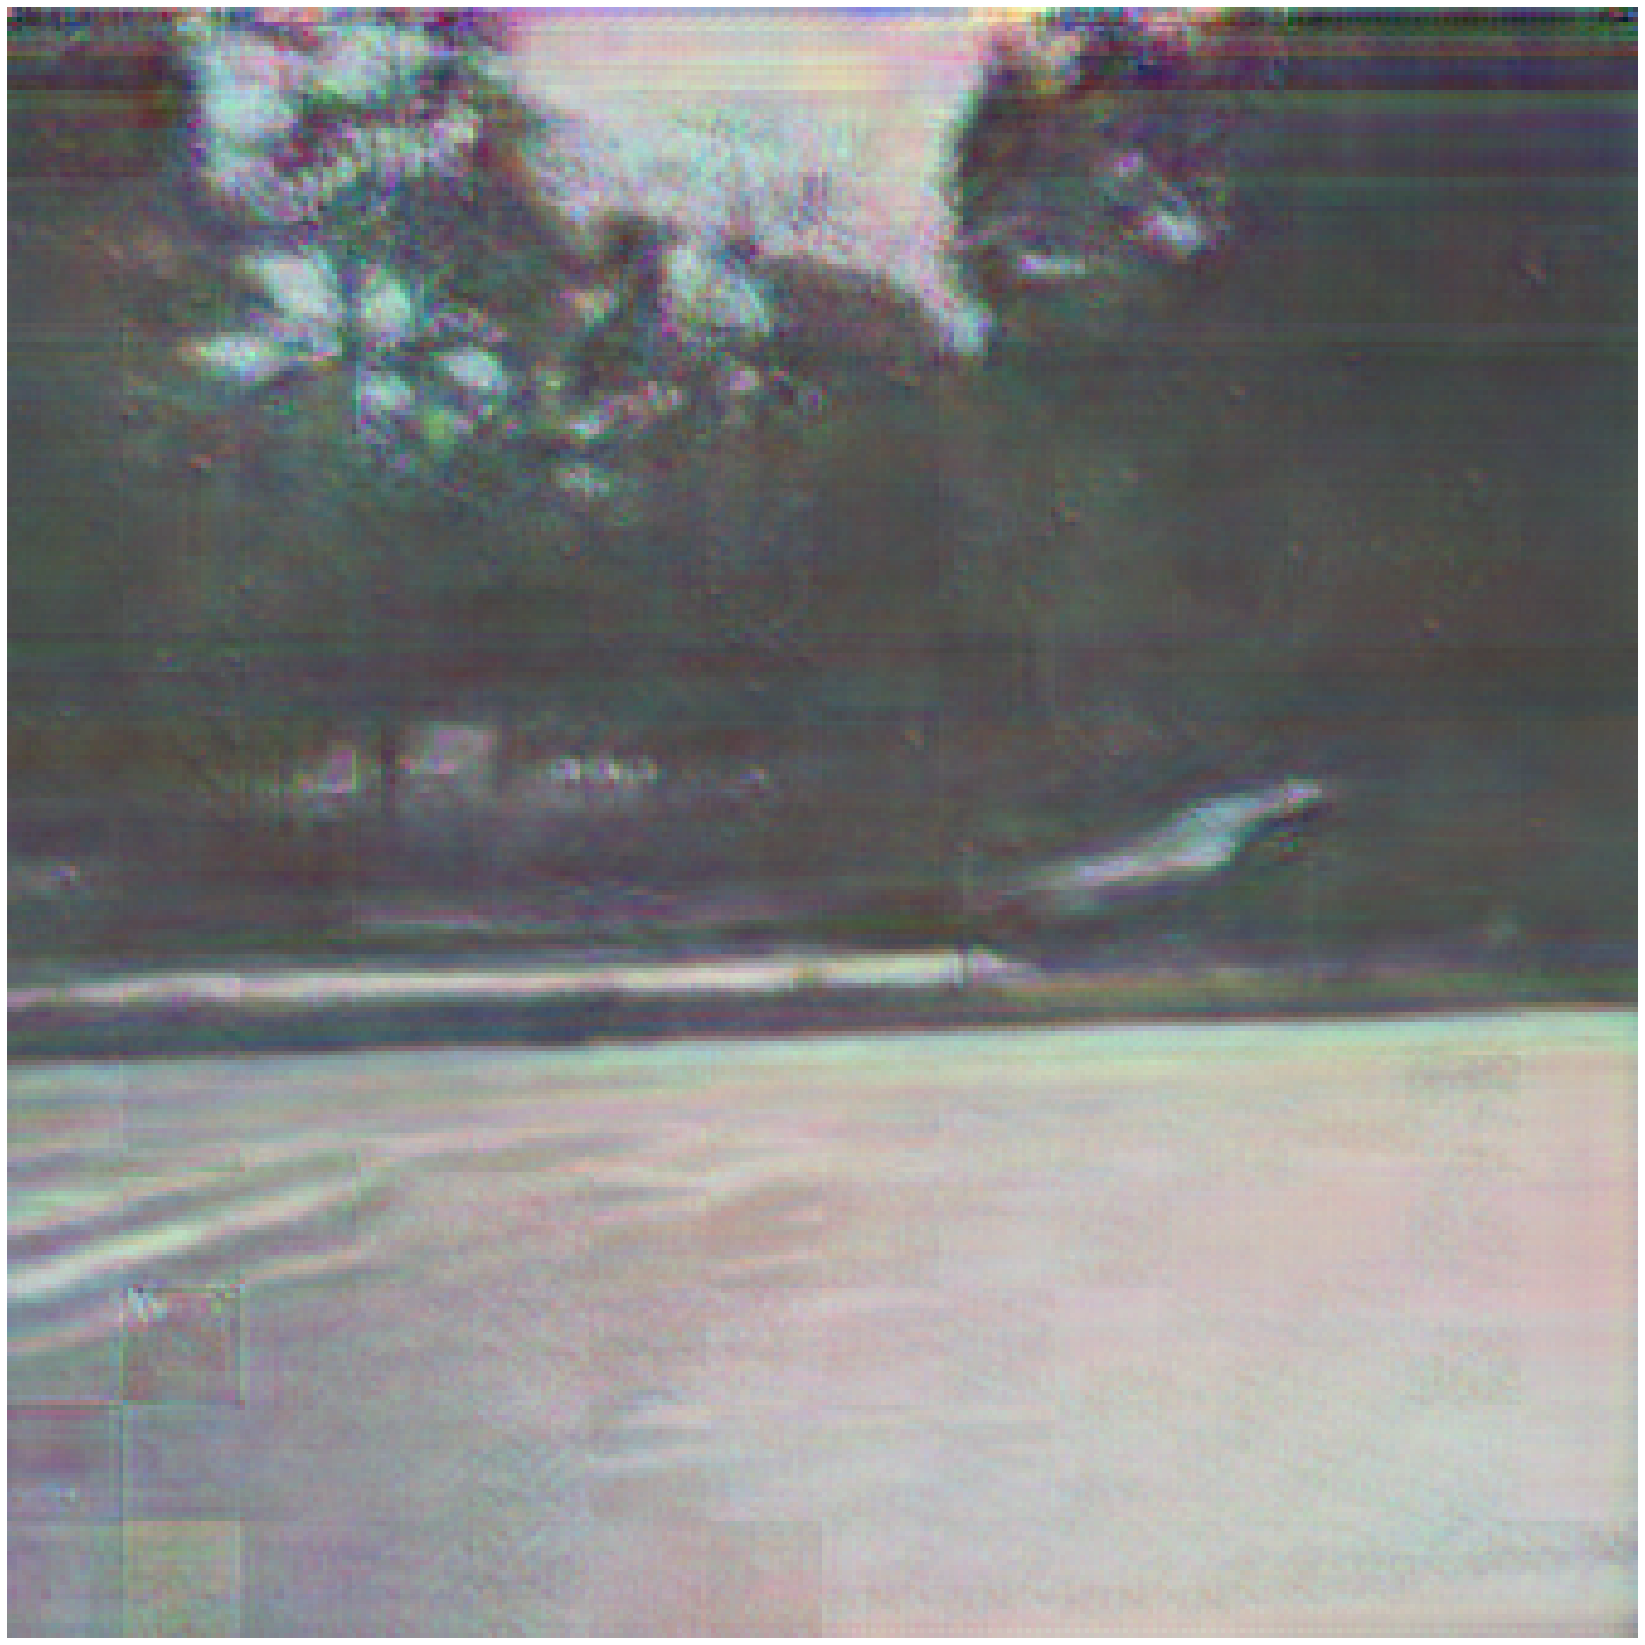

In [21]:
mt = preds[0][0]
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))

In [ ]:
learn.model.my_tuple[5]


In [ ]:
learn.data.train_ds[1][0].img

In [ ]:
learn.data.train_ds[1][0].si_img

In [ ]:
learn.loss_func.soft_bit_entropy

In [ ]:
config.si_loss_weight_alpha

In [ ]:
learn.loss_func.autoencoder_loss_value

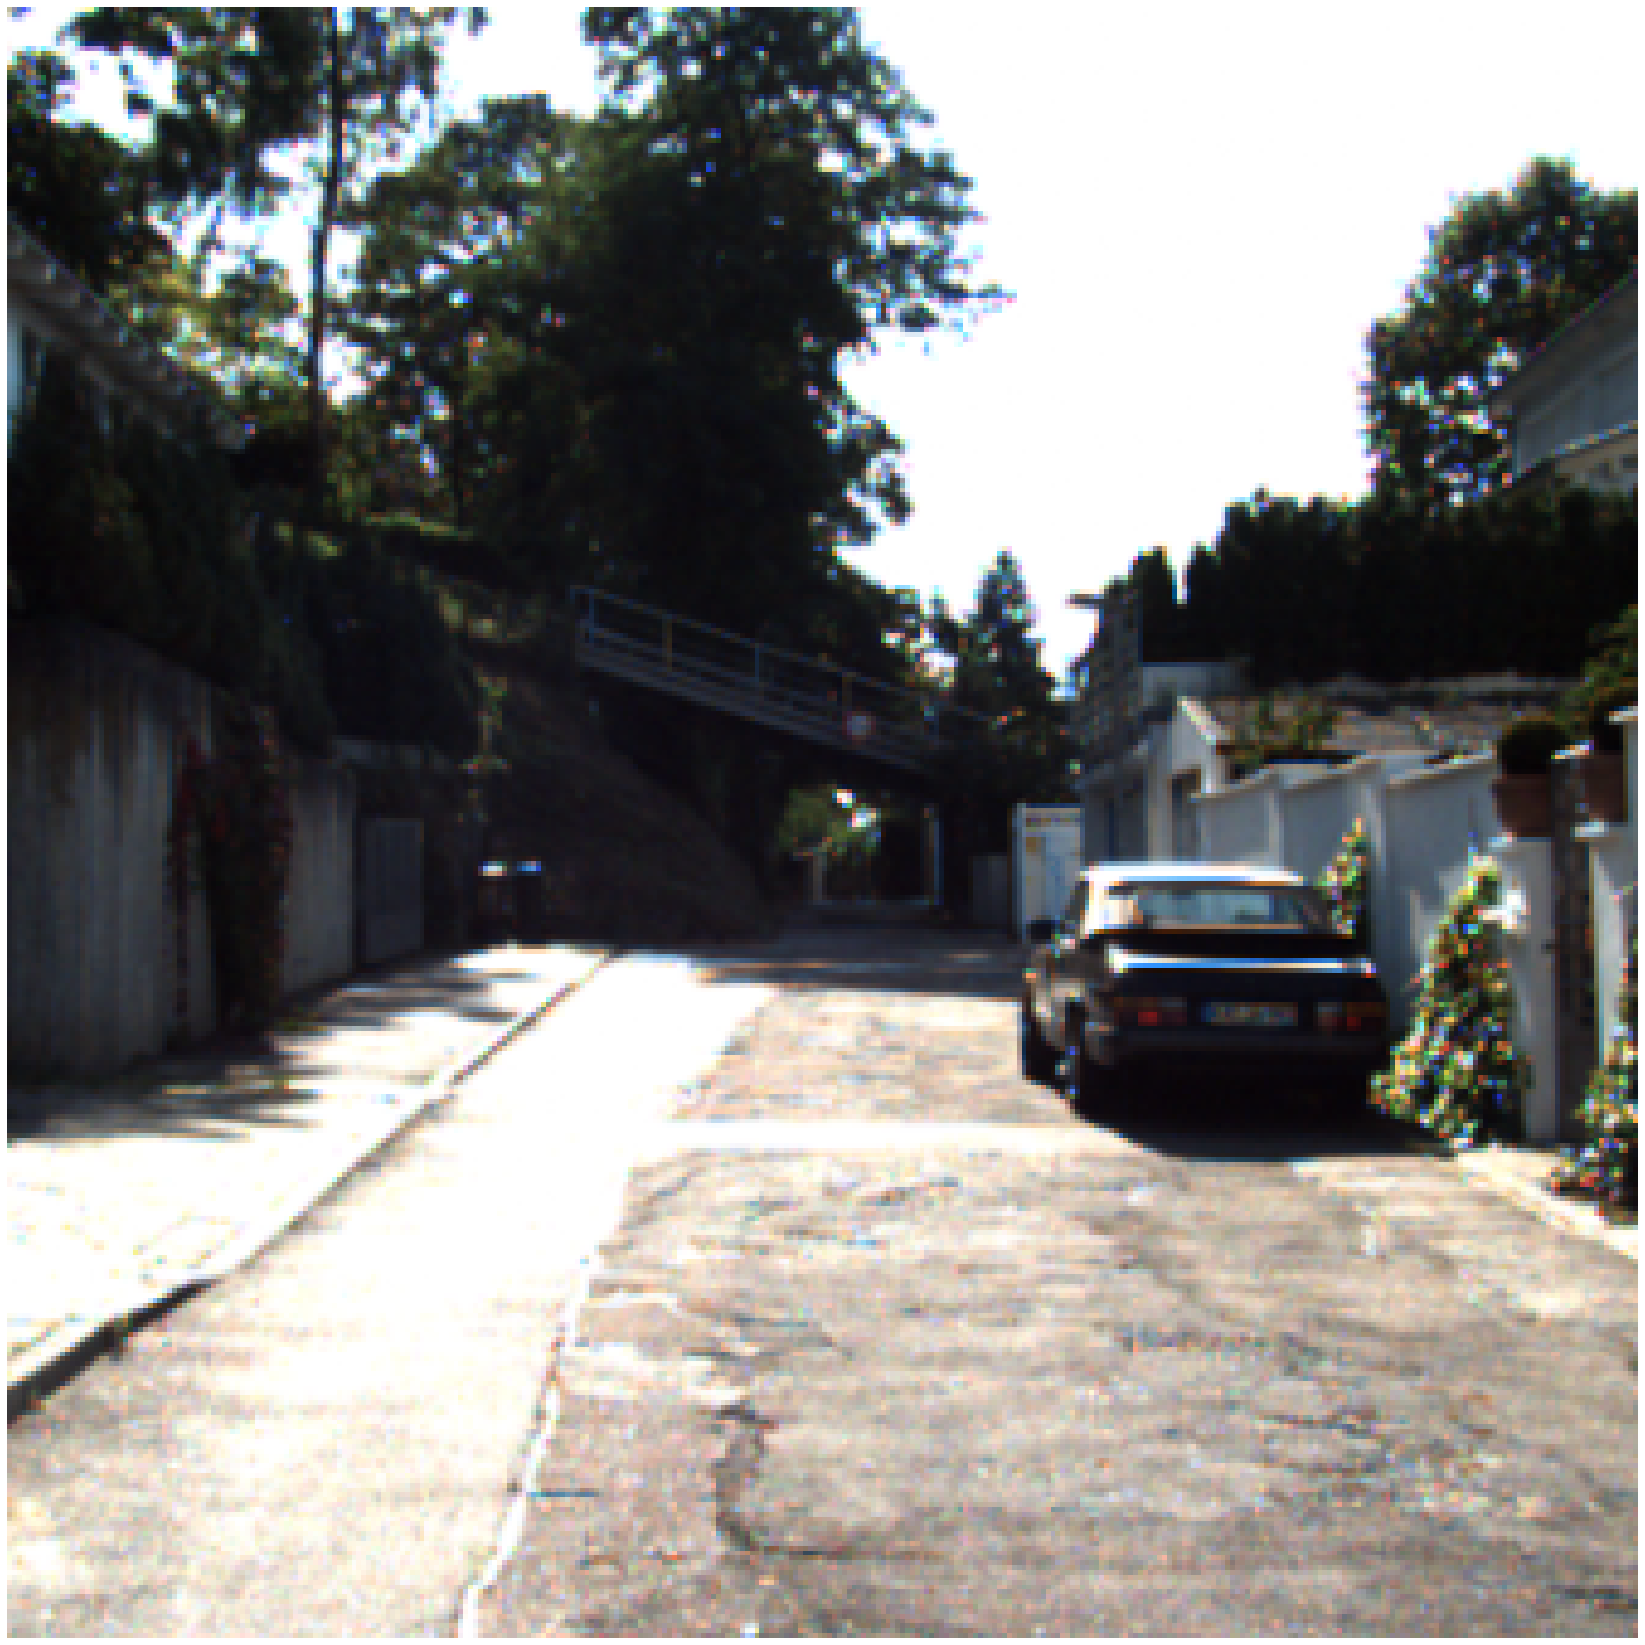

In [22]:
mt = learn.model.my_tuple[-1].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))
# # print(mn)

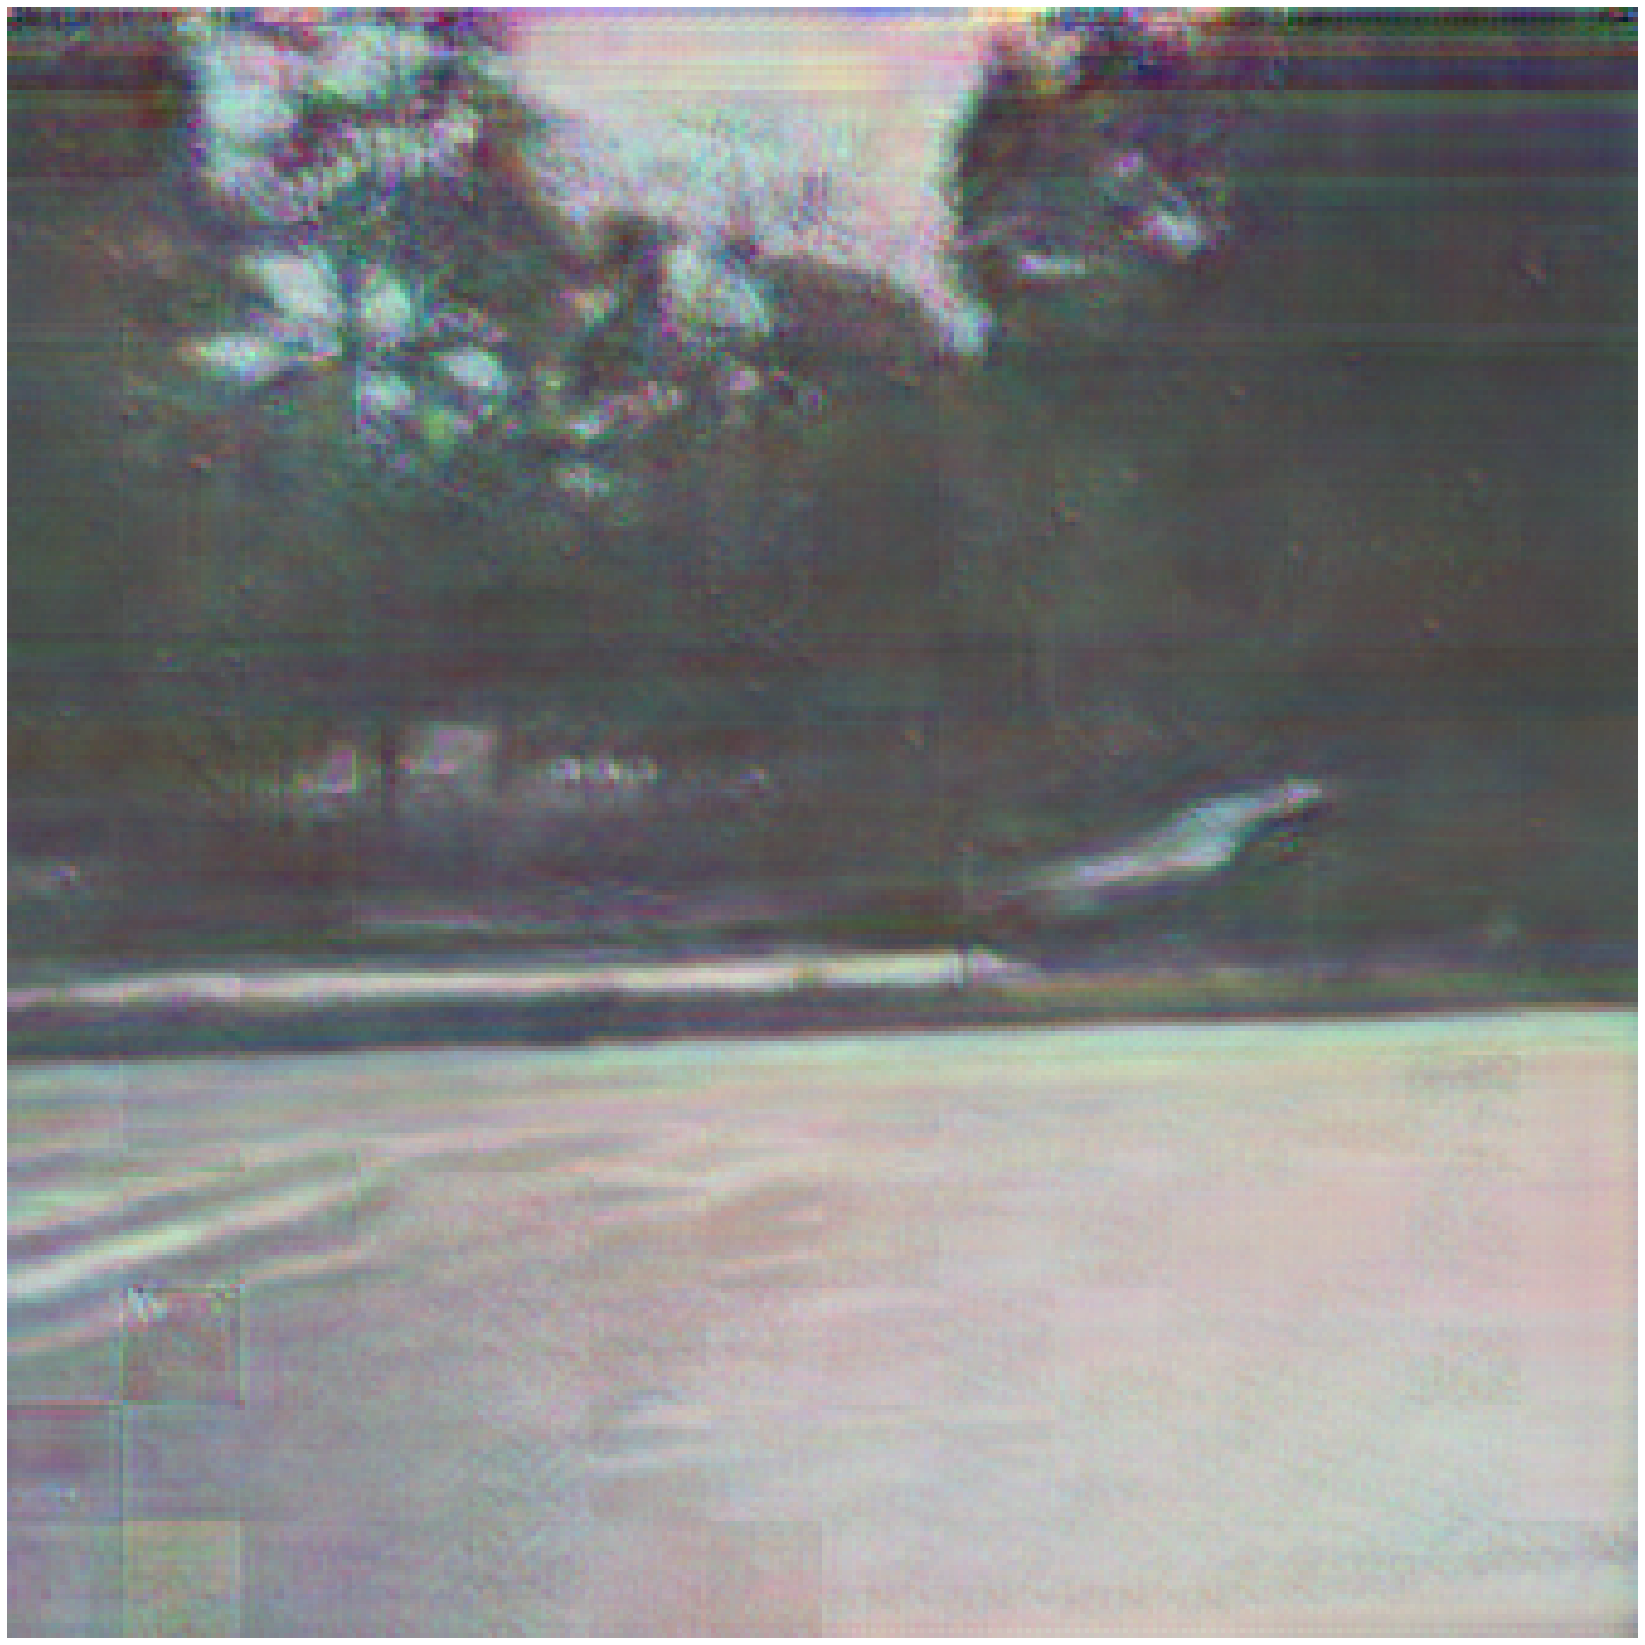

In [37]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
mt = learn.model.my_tuple[2].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))
# # print(mn)

# torch.min(learn.model.my_tuple[2].squeeze_().detach())

In [ ]:
aaa = (mt - mn)/(diff)

flip_lr(Image(aaa.cpu()))

In [ ]:
# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [ ]:
learn.model.my_tuple[-2].data